In [3]:
!pip install geopandas

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

import geopy as gp
import matplotlib.pyplot as plt
import requests
import shapely.geometry as geom

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from geopy.geocoders import Nominatim

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [49]:
!mkdir ./data
!wget https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_test.csv -P ./data
!wget https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_train.csv -P ./data

mkdir: cannot create directory ‘./data’: File exists
--2021-05-26 16:52:00--  https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4462 (4.4K) [text/plain]
Saving to: ‘./data/mf_geo_test.csv’

mf_geo_test.csv     100%[===================>]   4.36K  --.-KB/s    in 0s      

2021-05-26 16:52:00 (33.9 MB/s) - ‘./data/mf_geo_test.csv’ saved [4462/4462]

--2021-05-26 16:52:00--  https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP reque

## Nominatim

In [97]:
train = pd.read_csv('./data/mf_geo_train.csv')
test = pd.read_csv('./data/mf_geo_test.csv')

In [98]:
train.head(10)

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
5,ci9r9Fr2,92.926002,56.065908,-0.218497
6,O3tOF6uE,30.468500,59.921400,-1.039679
7,CO76tdVs,37.444304,55.850511,0.213704
8,GU0QclY1,92.903162,56.050290,-0.304937
9,CHtHXJLp,39.701709,47.234012,-0.132057


In [99]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   point_id  107 non-null    object 
 1   lon       107 non-null    float64
 2   lat       107 non-null    float64
 3   target    107 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.5+ KB


In [100]:
geolocator = Nominatim(user_agent='geoloc_req')

def city(lat, lon):
    location = geolocator.reverse(gp.point.Point([lat, lon]))
    address = location.raw['address']
    city = address.get('city', '')
    return city

In [101]:
train['city'] = [city(train['lat'][x], train['lon'][x]) for x in range(train.shape[0])]

In [102]:
test['city'] = [city(test['lat'][x], test['lon'][x]) for x in range(test.shape[0])]

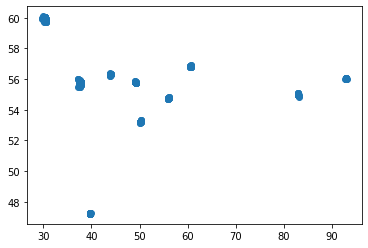

In [103]:
plt.plot(train['lon'], train['lat'], 'o')

In [104]:
msk_bbox = 37.3371,55.5358,37.8947,55.9333
ekb_bbox = 60.382659,56.699108,60.860147,56.944868
zlg_bbox = 37.131602,55.948008,37.268291,56.021224
kaz_bbox = 48.8206,55.6035,49.3812,55.9382
kra_bbox = 92.627132,55.91184,93.168561,56.133796
nno_bbox = 43.727046,56.187653,44.111958,56.401982
nsk_bbox = 82.751132,54.800904,83.160227,55.134817
rod_bbox = 39.404731,47.153377,39.85139,47.368733
sam_bbox = 49.746151,53.091673,50.390389,53.550744
stp_bbox = 30.043343,59.744148,30.567166,60.090737
ufa_bbox = 55.778578,54.500751,56.298556,54.959875
nsk_cd_bbox = 82.1691,54.5559,83.5191,55.438

city_bbox = {
    'Москва' : msk_bbox,
    'Екатеринбург' : ekb_bbox,
    'Зеленоград' : zlg_bbox,
    'Казань' : kaz_bbox,
    'Красноярск' : kra_bbox,
    'Нижний Новгород' : nno_bbox,
    'Новосибирск' : nsk_bbox,
    'Ростов-на-Дону' : rod_bbox,
    'Самара' : sam_bbox,
    'Санкт-Петербург' : stp_bbox,
    'Уфа' : ufa_bbox,
    'городской округ Новосибирск' : nsk_cd_bbox
}

In [105]:
train['bounds'] = train['city'].map(city_bbox)
test['bounds'] = test['city'].map(city_bbox)

In [37]:
train['city'].value_counts()

Москва                         154
Санкт-Петербург                 73
Самара                          27
Казань                          25
Екатеринбург                    22
Нижний Новгород                 21
Ростов-на-Дону                  21
Красноярск                      20
Уфа                             19
городской округ Новосибирск     14
Новосибирск                     12
                                 9
Колпино                          4
Зеленоград                       3
Пушкин                           1
Name: city, dtype: int64

## Административно-территориальное деление

использован ресурс https://mydata.biz/ru/catalog/databases/borders_ru

In [14]:
!wget https://mydata.biz/storage/download/94711ccda7f04a0ba9216d3483b4ad4c/%D0%90%D0%B4%D0%BC-%D1%82%D0%B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5%20%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D1%8B%20%D0%A0%D0%A4%20%D0%B2%20%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%82%D0%B5%20GeoJSON.zip -O ./data/ATD_Russia.zip

--2021-05-26 19:28:59--  https://mydata.biz/storage/download/94711ccda7f04a0ba9216d3483b4ad4c/%D0%90%D0%B4%D0%BC-%D1%82%D0%B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5%20%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D1%8B%20%D0%A0%D0%A4%20%D0%B2%20%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%82%D0%B5%20GeoJSON.zip
Resolving mydata.biz (mydata.biz)... 217.174.106.9
Connecting to mydata.biz (mydata.biz)|217.174.106.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87710649 (84M) [application/zip]
Saving to: ‘./data/ATD_Russia.zip’

./data/ATD_Russia.z   0%[                    ] 600.00K   171KB/s    eta 8m 31s ^C


In [66]:
!mkdir ./data/ATD_Russia

In [ ]:
import zipfile, glob

extract_dir = './data/ATD_Russia'

with zipfile.ZipFile('./data/ATD_Russia.zip') as zf:
    zf.extractall(extract_dir)

In [38]:
Russia_ATD_l4 = gpd.read_file('./data/ATD_Russia/admin_level_4.geojson')
Russia_ATD_l6 = gpd.read_file('./data/ATD_Russia/admin_level_6.geojson')

In [57]:
gpd_train = gpd.GeoDataFrame(train.drop(['city', 'bounds'], axis=1), geometry=gpd.points_from_xy(train.lon, train.lat))
gpd_test = gpd.GeoDataFrame(test.drop(['city', 'bounds'], axis=1), geometry=gpd.points_from_xy(test.lon, test.lat))

In [58]:
gpd_train

,point_id,lon,lat,target,geometry
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863)
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027)
2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333)
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202)
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019)
...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,POINT (37.62877 55.74066)
421,uNw6t6xk,37.586825,55.794233,-0.002397,POINT (37.58682 55.79423)
422,Ap42ei8k,37.678790,55.772910,-0.910019,POINT (37.67879 55.77291)
423,rn9A8r62,37.752130,55.619640,-0.326547,POINT (37.75213 55.61964)


In [59]:
gpd_train = gpd.sjoin(gpd_train, Russia_ATD_l4[['name', 'geometry']], how='left')
gpd_train = gpd_train.drop(['index_right'], axis=1)
gpd_test = gpd.sjoin(gpd_test, Russia_ATD_l4[['name', 'geometry']], how='left')
gpd_test = gpd_test.drop(['index_right'], axis=1)

In [60]:
gpd_train = gpd.sjoin(gpd_train, Russia_ATD_l6[['name', 'geometry']], how='left')
gpd_train = gpd_train.drop(['index_right'], axis=1)
gpd_test = gpd.sjoin(gpd_test, Russia_ATD_l6[['name', 'geometry']], how='left')
gpd_test = gpd_test.drop(['index_right'], axis=1)

In [61]:
gpd_train['name_right'].fillna(gpd_train['name_left'], inplace=True)
gpd_test['name_right'].fillna(gpd_test['name_left'], inplace=True)
gpd_train = gpd_train.drop(['name_left'], axis=1)
gpd_test = gpd_test.drop(['name_left'], axis=1)
gpd_train = gpd_train.rename(columns={'name_right' : 'city'})
gpd_test = gpd_test.rename(columns={'name_right' : 'city'})

In [62]:
gpd_train

,point_id,lon,lat,target,geometry,city
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва
2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),городской округ Ростов-на-Дону
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва
...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,POINT (37.62877 55.74066),Москва
421,uNw6t6xk,37.586825,55.794233,-0.002397,POINT (37.58682 55.79423),Москва
422,Ap42ei8k,37.678790,55.772910,-0.910019,POINT (37.67879 55.77291),Москва
423,rn9A8r62,37.752130,55.619640,-0.326547,POINT (37.75213 55.61964),Москва


In [63]:
gpd_train['city'].value_counts()

Москва                             161
Санкт-Петербург                     83
городской округ Самара              27
городской округ Новосибирск         26
городской округ Казань              25
городской округ Екатеринбург        22
городской округ Ростов-на-Дону      21
городской округ Нижний Новгород     21
городской округ Красноярск          20
городской округ Уфа                 19
Name: city, dtype: int64

## Карта

In [ ]:
gpd_train.set_crs(epsg=4326, inplace=True)
gpd_train = gpd_train.to_crs(epsg=3857)
gpd_test.set_crs(epsg=4326, inplace=True)
gpd_test = gpd_test.to_crs(epsg=3857)

In [83]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[63.55, 94.35], 
               zoom_start=3, 
               tiles='cartodbpositron')

heat_data = [[row['lat'],row['lon']] for idx, row in gpd_train.iterrows()]


HeatMap(heat_data,
        radius=10).add_to(m)

m

### Fit model

In [110]:
!pip install catboost

     |████████████████████████████████| 67.3MB 47kB/s 


In [111]:
from catboost import Pool, CatBoostRegressor

In [120]:
train_pool = Pool(train.drop(['target', 'point_id', 'bounds'], axis=1),
                  train['target'],
                  cat_features=[2])
test_pool = Pool(test.drop(['target', 'point_id', 'bounds'], axis=1),
                 cat_features=[2])

In [121]:
model = CatBoostRegressor(iterations=2, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='MAE')

In [122]:
model.fit(train_pool)
preds = model.predict(test_pool)

0:	learn: 0.6482496	total: 47.1ms	remaining: 47.1ms
1:	learn: 0.6479445	total: 47.7ms	remaining: 0us


In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   point_id  425 non-null    object 
 1   lon       425 non-null    float64
 2   lat       425 non-null    float64
 3   target    425 non-null    float64
 4   city      425 non-null    object 
 5   bounds    411 non-null    object 
dtypes: float64(3), object(3)
memory usage: 20.0+ KB


In [ ]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.8108264141723872

### Make submission

In [123]:
submission = pd.DataFrame({'point_id' : test['point_id'], 'target' : preds})
submission.to_csv('data/my_submission_01.csv', index=False)